<a href="https://colab.research.google.com/github/nachovazquez98/cancer-svm-pca-shap/blob/main/cancer_svm_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 13 15:37:12 2020

@author: nacho
"""
import sys, os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RepeatedKFold
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn import metrics


In [10]:
#Visualizar pca em 2D y 3D
class pca():
    def __init__(self,  df=None, titulo="Unspecified", label_y=None):
        self.df = df
        self.label_y = str(label_y)
        self.titulo = str(titulo)
        print(list(df))
        print(f"Numero de elementos de {label_y}\n", df[label_y].value_counts())
    def pca_2D(self):
        df_PCA = self.df.drop([self.label_y], axis=1)
        #instanciamos el metodo pca con 2 componentes
        pca = PCA(n_components=2)
        #encontramos los componentes principales usando 
        #el método de ajuste con 2 componentes
        #transformamos los datos scaled_data en 2 componentes con pca
        pca.fit(df_PCA)
        x_pca = pca.transform(df_PCA)
        ######
        #instanciamos un objeto para hacer PCA
        scaler = StandardScaler()
        #escalar los datos, estandarizarlos, para que cada
        #caracteristica tenga una varianza unitaria 
        scaler.fit(df_PCA)
        #aplicamos la reducción de rotación y dimensionalidad
        scaled_data = scaler.transform(df_PCA)
        pca = PCA().fit(scaled_data)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
        plt.title('How many components are needed to describe the data.')
        ######
        print("Dimension de los features orginales: ", df_PCA.shape)
        print("Dimension de los features con 2 componentes", x_pca.shape)
        
        #visualizar los datos en 2 dimensiones
        #plt.figure(figsize=(8,6))
        fig, ax = plt.subplots()
        scatter = plt.scatter(x_pca[:,0],
                    x_pca[:,1],
                    c=self.df[self.label_y],
                    cmap='rainbow',
                    marker='o',
                    s=2,
                    linewidths=0)
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".", ls="", 
                              color=scatter.cmap(scatter.norm(yi))) for yi in labels]
        plt.legend(handles, labels)
        plt.xlabel('First principal component')
        plt.ylabel('Second Principal Component')
        plt.title(self.titulo)
        #plt.show()
        y = self.df[self.label_y]
        return x_pca, y
    def pca_3D(self):
        sns.set_style("white")  
        self.df[self.label_y] = pd.Categorical(self.df[self.label_y])
        my_color = self.df[self.label_y].cat.codes
        df_PCA = self.df.drop([self.label_y], axis=1)
        pca = PCA(n_components=3)
        pca.fit(df_PCA)
        result=pd.DataFrame(pca.transform(df_PCA), 
                            columns=['PCA%i' % i for i in range(3)], 
                            index=df_PCA.index)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scat = ax.scatter(result['PCA0'], 
                   result['PCA1'], 
                   result['PCA2'], 
                   c=my_color, 
                   cmap='rainbow', 
                   s=2, marker="o",
                   linewidths=0)
        
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".",ls="",
                                 color=scat.cmap(scat.norm(yi))) for yi in labels]               
        ax.legend(handles, labels)
        
        # make simple, bare axis lines through space:
        xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
        ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
        yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
        ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
        zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
        ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
         
        # label the axes
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title(self.titulo)
        #plt.show()
        fig.tight_layout()
        y = self.df[self.label_y]
        return result, y

In [11]:
#Visualizar smv en 2d   
def plot_svm_2d(grid, X_test, Y_test):
    scaler1 = StandardScaler()
    scaler1.fit(X_test)
    X_test_scaled = scaler1.transform(X_test)
    
    
    pca1 = PCA(n_components=2)
    X_test_scaled_reduced = pca1.fit_transform(X_test_scaled)
    
    
    svm_model = SVC(kernel='rbf', C=float(grid.best_params_['SupVM__C']), 
                    gamma=float(grid.best_params_['SupVM__gamma']))
    
    classify = svm_model.fit(X_test_scaled_reduced, Y_test)
    
    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out
    
    def make_meshgrid(x, y, h=.1):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))#,
                             #np.arange(z_min, z_max, h))
        return xx, yy
    
    X0, X1 = X_test_scaled_reduced[:, 0], X_test_scaled_reduced[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    fig, ax = plt.subplots(figsize=(12,9))
    fig.patch.set_facecolor('white')
    cdict1={0:'lime',1:'deeppink'}
    
    Y_tar_list = Y_test.tolist()
    yl1= [int(target1) for target1 in Y_tar_list]
    labels1=yl1
     
    labl1={0:'Malignant',1:'Benign'}
    marker1={0:'*',1:'d'}
    alpha1={0:.8, 1:0.5}
    
    for l1 in np.unique(labels1):
        ix1=np.where(labels1==l1)
        ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])
    
    ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=40, facecolors='none', 
               edgecolors='navy', label='Support Vectors')
    
    plot_contours(ax, classify, xx, yy,cmap='seismic', alpha=0.4)
    plt.legend(fontsize=15)
    
    plt.xlabel("1st Principal Component",fontsize=14)
    plt.ylabel("2nd Principal Component",fontsize=14)
    plt.show()

In [13]:
#entrenamiento cross-validation con hiperparámetros de SVC
def gridsearchcv(X, y, n_pca=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2, stratify=y, shuffle=True)
    pipe_steps_pca = [('scaler', StandardScaler()),('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]
    param_grid_pca= {
        'pca__n_components': [n_pca], 
        'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
        'SupVM__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
    }
    pipe_steps = [('scaler', StandardScaler()), ('SupVM', SVC(kernel='rbf'))]
    param_grid= {
            'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
            'SupVM__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
    }
    if n_pca != None:
        pipeline = Pipeline(pipe_steps_pca)
        grid = GridSearchCV(pipeline, param_grid_pca,refit = True,verbose = 1, n_jobs=-1 ,scoring='balanced_accuracy')
    else:
        pipeline = Pipeline(pipe_steps)
        grid = GridSearchCV(pipeline, param_grid,refit = True,verbose = 1, n_jobs=-1, scoring='balanced_accuracy')
    grid.fit(X_train, Y_train)
    print("Best-Fit Parameters From Training Data:\n",grid.best_params_)
    grid_predictions = grid.predict(X_test) 
    report = classification_report(Y_test, grid_predictions, output_dict=True)
    report = pd.DataFrame(report).transpose()
    print(report)
    print(confusion_matrix(Y_test, grid_predictions))
    return grid, report, X_test, Y_test

Se importa el dataset y se guarda como un Dataframe

In [14]:
from sklearn.datasets import load_breast_cancer 
cancer = load_breast_cancer() 
df = pd.DataFrame(cancer['data'], columns = cancer['feature_names']) 
df['target'] = cancer['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']
Numero de elementos de target
 1    357
0    212
Name: target, dtype: int64
Dimension de los features orginales:  (569, 30)
Dimension de los features con 2 componentes (569, 2)


(            PCA0        PCA1       PCA2
 0    1160.142574 -293.917544  48.578398
 1    1269.122443   15.630182 -35.394534
 2     995.793889   39.156743  -1.709753
 3    -407.180803  -67.380320   8.672848
 4     930.341180  189.340742   1.374801
 ..           ...         ...        ...
 564  1414.126684  110.222492  40.065944
 565  1045.018854   77.057589   0.036669
 566   314.501756   47.553525 -10.442407
 567  1124.858115   34.129225 -19.742087
 568  -771.527622  -88.643106  23.889032
 
 [569 rows x 3 columns], 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 564    0
 565    0
 566    0
 567    0
 568    1
 Name: target, Length: 569, dtype: category
 Categories (2, int64): [0, 1])

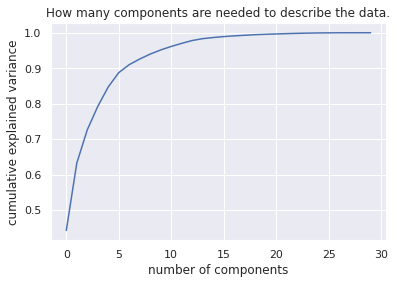

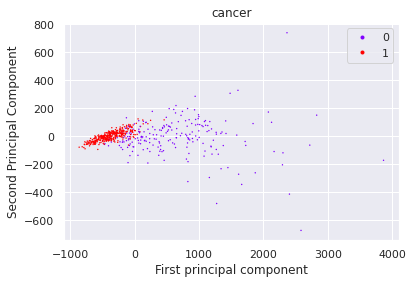

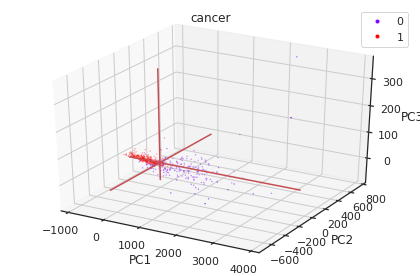

In [15]:
#visualizacion pca
cancer_pca = pca(df, titulo="cancer", label_y='target')
cancer_pca.pca_2D(); cancer_pca.pca_3D()

In [16]:
#separar datos
X = df.iloc[:,:-1]
y = df.iloc[:,-1]


In [17]:
# feature selection
def select_features(best_params, X, y):
    fs = SelectKBest(score_func=mutual_info_regression, k=best_params)
    # learn relationship from training data
    fs.fit(X,y)
    cols = fs.get_support(indices=True)
    X_fs = X.iloc[:,cols]
    return X_fs

# feature selection
best_params = 13
X_fs = select_features(best_params, X, y)

In [18]:
#trainSelectKBest
cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X,y)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best-Fit Parameters From Training Data:
 {'SupVM__C': 10, 'SupVM__gamma': 0.005}
              precision    recall  f1-score     support
0              1.000000  0.857143  0.923077   42.000000
1              0.923077  1.000000  0.960000   72.000000
accuracy       0.947368  0.947368  0.947368    0.947368
macro avg      0.961538  0.928571  0.941538  114.000000
weighted avg   0.951417  0.947368  0.946397  114.000000
[[36  6]
 [ 0 72]]


Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best-Fit Parameters From Training Data:
 {'SupVM__C': 1000, 'SupVM__gamma': 0.001, 'pca__n_components': 2}
              precision    recall  f1-score     support
0              0.975000  0.928571  0.951220   42.000000
1              0.959459  0.986111  0.972603   72.000000
accuracy       0.964912  0.964912  0.964912    0.964912
macro avg      0.967230  0.957341  0.961911  114.000000
weighted avg   0.965185  0.964912  0.964725  114.000000
[[39  3]
 [ 1 71]]


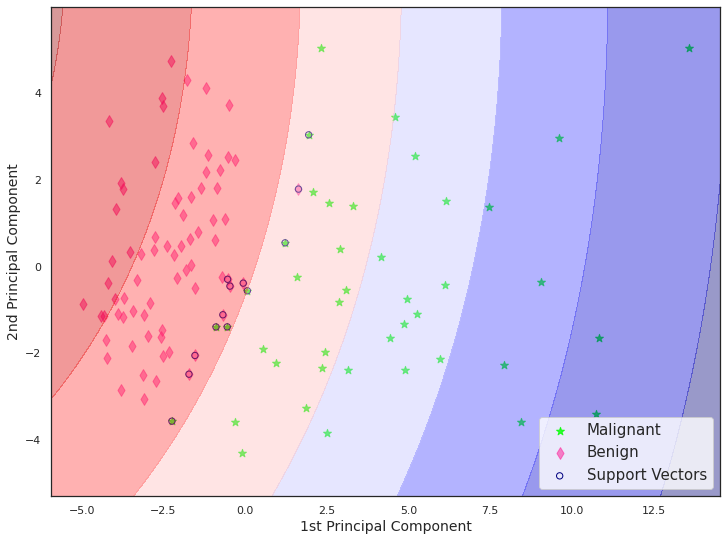

In [19]:
cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X,y, n_pca=2)
#grafica modelo en 2d
plot_svm_2d(cancer_grid, X_test, Y_test)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best-Fit Parameters From Training Data:
 {'SupVM__C': 0.1, 'SupVM__gamma': 0.5, 'pca__n_components': 2}
              precision    recall  f1-score     support
0              0.902439  0.880952  0.891566   42.000000
1              0.931507  0.944444  0.937931   72.000000
accuracy       0.921053  0.921053  0.921053    0.921053
macro avg      0.916973  0.912698  0.914749  114.000000
weighted avg   0.920798  0.921053  0.920849  114.000000
[[37  5]
 [ 4 68]]


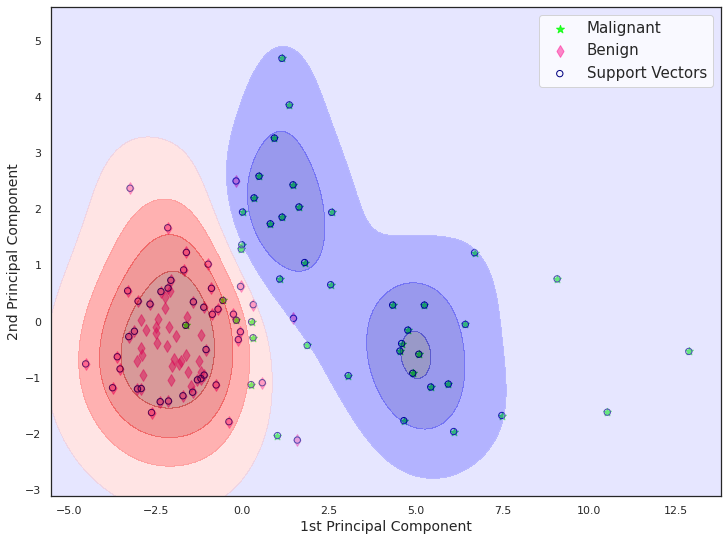

In [20]:
cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X_fs,y, n_pca=2)
#grafica modelo en 2d
plot_svm_2d(cancer_grid, X_test, Y_test)


In [21]:
cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X,y, n_pca=3)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best-Fit Parameters From Training Data:
 {'SupVM__C': 40, 'SupVM__gamma': 0.01, 'pca__n_components': 3}
              precision    recall  f1-score     support
0              0.972973  0.857143  0.911392   42.000000
1              0.922078  0.986111  0.953020   72.000000
accuracy       0.938596  0.938596  0.938596    0.938596
macro avg      0.947525  0.921627  0.932206  114.000000
weighted avg   0.940829  0.938596  0.937684  114.000000
[[36  6]
 [ 1 71]]


In [22]:
cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X_fs,y, n_pca=3)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best-Fit Parameters From Training Data:
 {'SupVM__C': 1000, 'SupVM__gamma': 0.005, 'pca__n_components': 3}
              precision    recall  f1-score     support
0              0.972222  0.833333  0.897436   42.000000
1              0.910256  0.986111  0.946667   72.000000
accuracy       0.929825  0.929825  0.929825    0.929825
macro avg      0.941239  0.909722  0.922051  114.000000
weighted avg   0.933086  0.929825  0.928529  114.000000
[[35  7]
 [ 1 71]]


In [23]:
cancer_grid, cancer_grid_report, X_test, Y_test = gridsearchcv(X_fs,y)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best-Fit Parameters From Training Data:
 {'SupVM__C': 10, 'SupVM__gamma': 0.1}
              precision    recall  f1-score     support
0              0.975000  0.928571  0.951220   42.000000
1              0.959459  0.986111  0.972603   72.000000
accuracy       0.964912  0.964912  0.964912    0.964912
macro avg      0.967230  0.957341  0.961911  114.000000
weighted avg   0.965185  0.964912  0.964725  114.000000
[[39  3]
 [ 1 71]]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y,test_size=0.2, stratify=y, shuffle=True)

In [25]:
cancer_grid.best_params_

{'SupVM__C': 10, 'SupVM__gamma': 0.1}

In [26]:
svc_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('SupVM', SVC(kernel='rbf', probability=True)
    )])

svc_model.set_params(**cancer_grid.best_params_)
svc_model.get_params("model")
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [28]:
!pip install shap

     |████████████████████████████████| 564 kB 11.9 MB/s 


In [29]:
import shap

In [30]:
#se preprocesan los datos
X_train_scaled = pd.DataFrame(svc_model.named_steps['scaler'].fit_transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(svc_model.named_steps['scaler'].fit_transform(X_test),columns = X_test.columns)

In [31]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model = svc_model.named_steps['SupVM'].predict_proba, data = X_train_scaled, link = 'logit')
shap_values = explainer.shap_values(X = X_test_scaled, nsamples = 30, l1_reg="num_features(13)")

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/114 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.904e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.069e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.787e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.481e-04, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Droppin

In [32]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 2
Shape of each element: (114, 13)


In [33]:
#prediction and probability of model
print(f'Prediction for 1st sample in X_test: ', svc_model.named_steps['SupVM'].predict(X_test_scaled.iloc[[0], :])[0])
print(f'Prediction probability for 1st sample in X_test: ', svc_model.named_steps['SupVM'].predict_proba(X_test_scaled.iloc[[0], :])[0])


Prediction for 1st sample in X_test:  1
Prediction probability for 1st sample in X_test:  [0.09532362 0.90467638]


X has feature names, but SVC was fitted without feature names
X has feature names, but SVC was fitted without feature names


In [34]:
#Real value
print("Real value:", y_test.iloc[0])
X_test.iloc[[0], :]

Real value: 1


,mean radius,mean perimeter,mean area,mean concavity,mean concave points,radius error,perimeter error,area error,worst radius,worst perimeter,worst area,worst concavity,worst concave points
314,8.597,54.09,221.2,0.0,0.0,0.3368,2.222,17.81,8.952,56.65,240.1,0.0,0.0


In [35]:
# plot the SHAP values for the false (0) output of the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_scaled.iloc[0,:], link="logit")


In [36]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_scaled.iloc[0,:], link="logit")

In [37]:
#Explaining the Prediction for all samples in Test set
#no hospitalizado
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_scaled)

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_scaled)

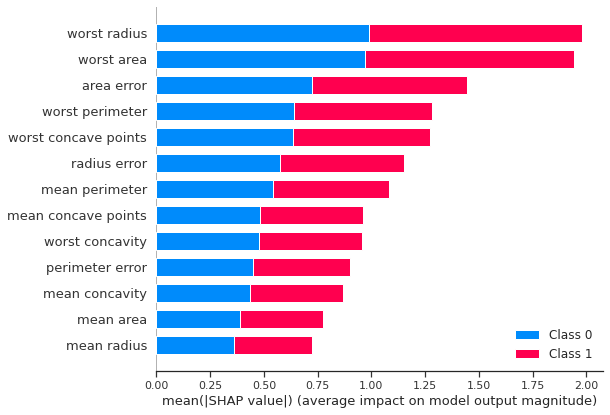

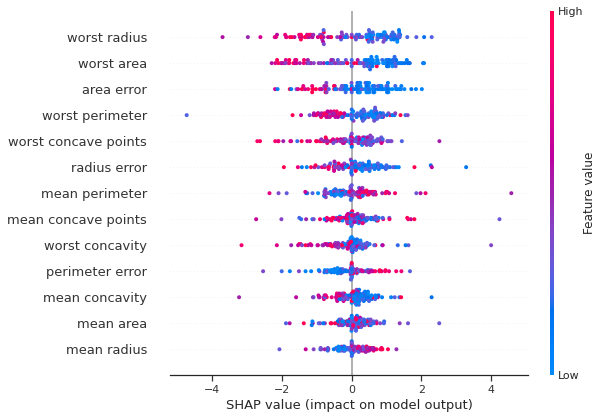

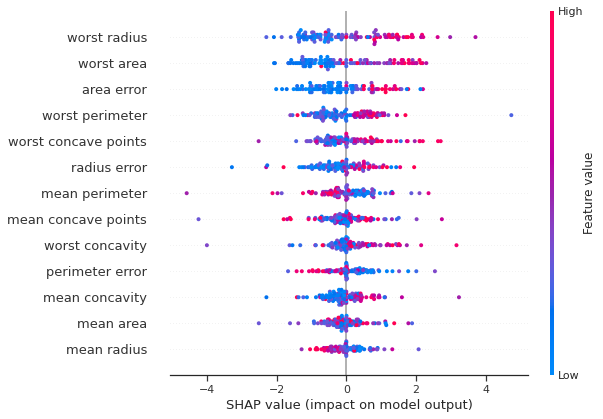

In [39]:
#SHAP Summary Plots
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values[1], X_test_scaled)
shap.summary_plot(shap_values[0], X_test_scaled)

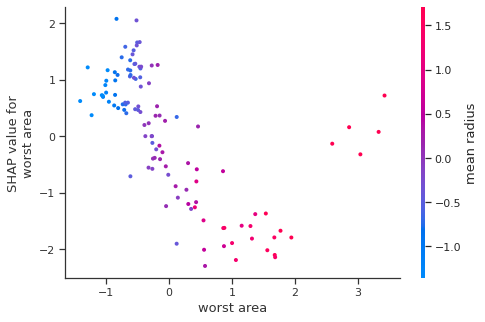

In [40]:
#SHAP Dependence Plots
shap.dependence_plot("worst area", shap_values[1], X_test_scaled)